# Homework 2

## Navigation
* [1. Import librarys and data](#section1)
* [2. Data cleaning and preprocess](#section2)
* [3. Decision Tree](#section3)
  - [Experiments on decision tree](#section31)
    - [Default params](#section331)
    - [Change max depth](#section332)
    - [Change max features](#section333)
    - [Analysis changes](#section334)
* [5. Bagging and Boosting](#section4)
  - [Bagging](#section41)
  - [Boosting](#section42)
  - [Analysis bagging and boosting](#section43)

<a id='section1'></a>
### Import librarys and data

In [1]:
import os
import pdb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import join, exists

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
data_path = "./smoke_detection_iot.csv"
df = pd.read_csv(data_path)

<a id='section2'></a>
### Data cleaning and preprocess

In [3]:
# Normalize
df = (df - np.min(df)) / (np.max(df) - np.min(df))

# Same cleaning step from Homework 1 since using the same dataset
df = df.drop(columns=["Unnamed: 0", "UTC", "CNT"])

X = df.copy().drop('Fire Alarm', axis=1).values
Y = df.copy()['Fire Alarm'].values
# train/test/val split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=9)
# X_val, X_test, Y_val, Y_test= train_test_split(X_train, Y_train, train_size=0.5)

<a id='section3'></a>
### Decision Tree

In [4]:
def build_decision_tree_clf(X_train, Y_train, train=True, max_depth=None, min_samples_split=2, max_features=None):
    clf = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
    )
    if train:
        clf = clf.fit(X_train, Y_train)
    return clf

In [5]:
def predict(clf, X_test, use_prob=False):
    if use_prob:
        pred = clf.predict_proba(X_test)
    else:
        pred = clf.predict(X_test)
    return pred

In [6]:
def build_cv(n_splits=10, n_repeats=5, random_state=8):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    return cv

In [7]:
def evaluate(clf, X, Y, cv, scoring='roc_auc', n_jobs=-1, error_score='raise'):
    n_scores = cross_val_score(clf, X, Y, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score)
    mean_accuracy = np.mean(n_scores)
    std_accuracy = np.std(n_scores)
    return mean_accuracy, std_accuracy

<a id='section31'></a>
#### Experiments on decision tree

In [8]:
# Record experiment results
results = {
    'experiment': [],
    'cv_accuracy': [],
    'youden_index': []
}
confusion_matrices = {}

<a id='section331'></a>
##### Default params

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 8
	tree max features: 12
Cross validation accuracy: 0.9998378087515922 (0.00022388787801676846)
Youden's index: 0.9987723955757073


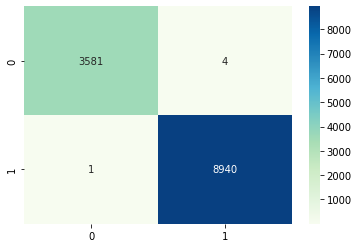

<Figure size 432x288 with 0 Axes>

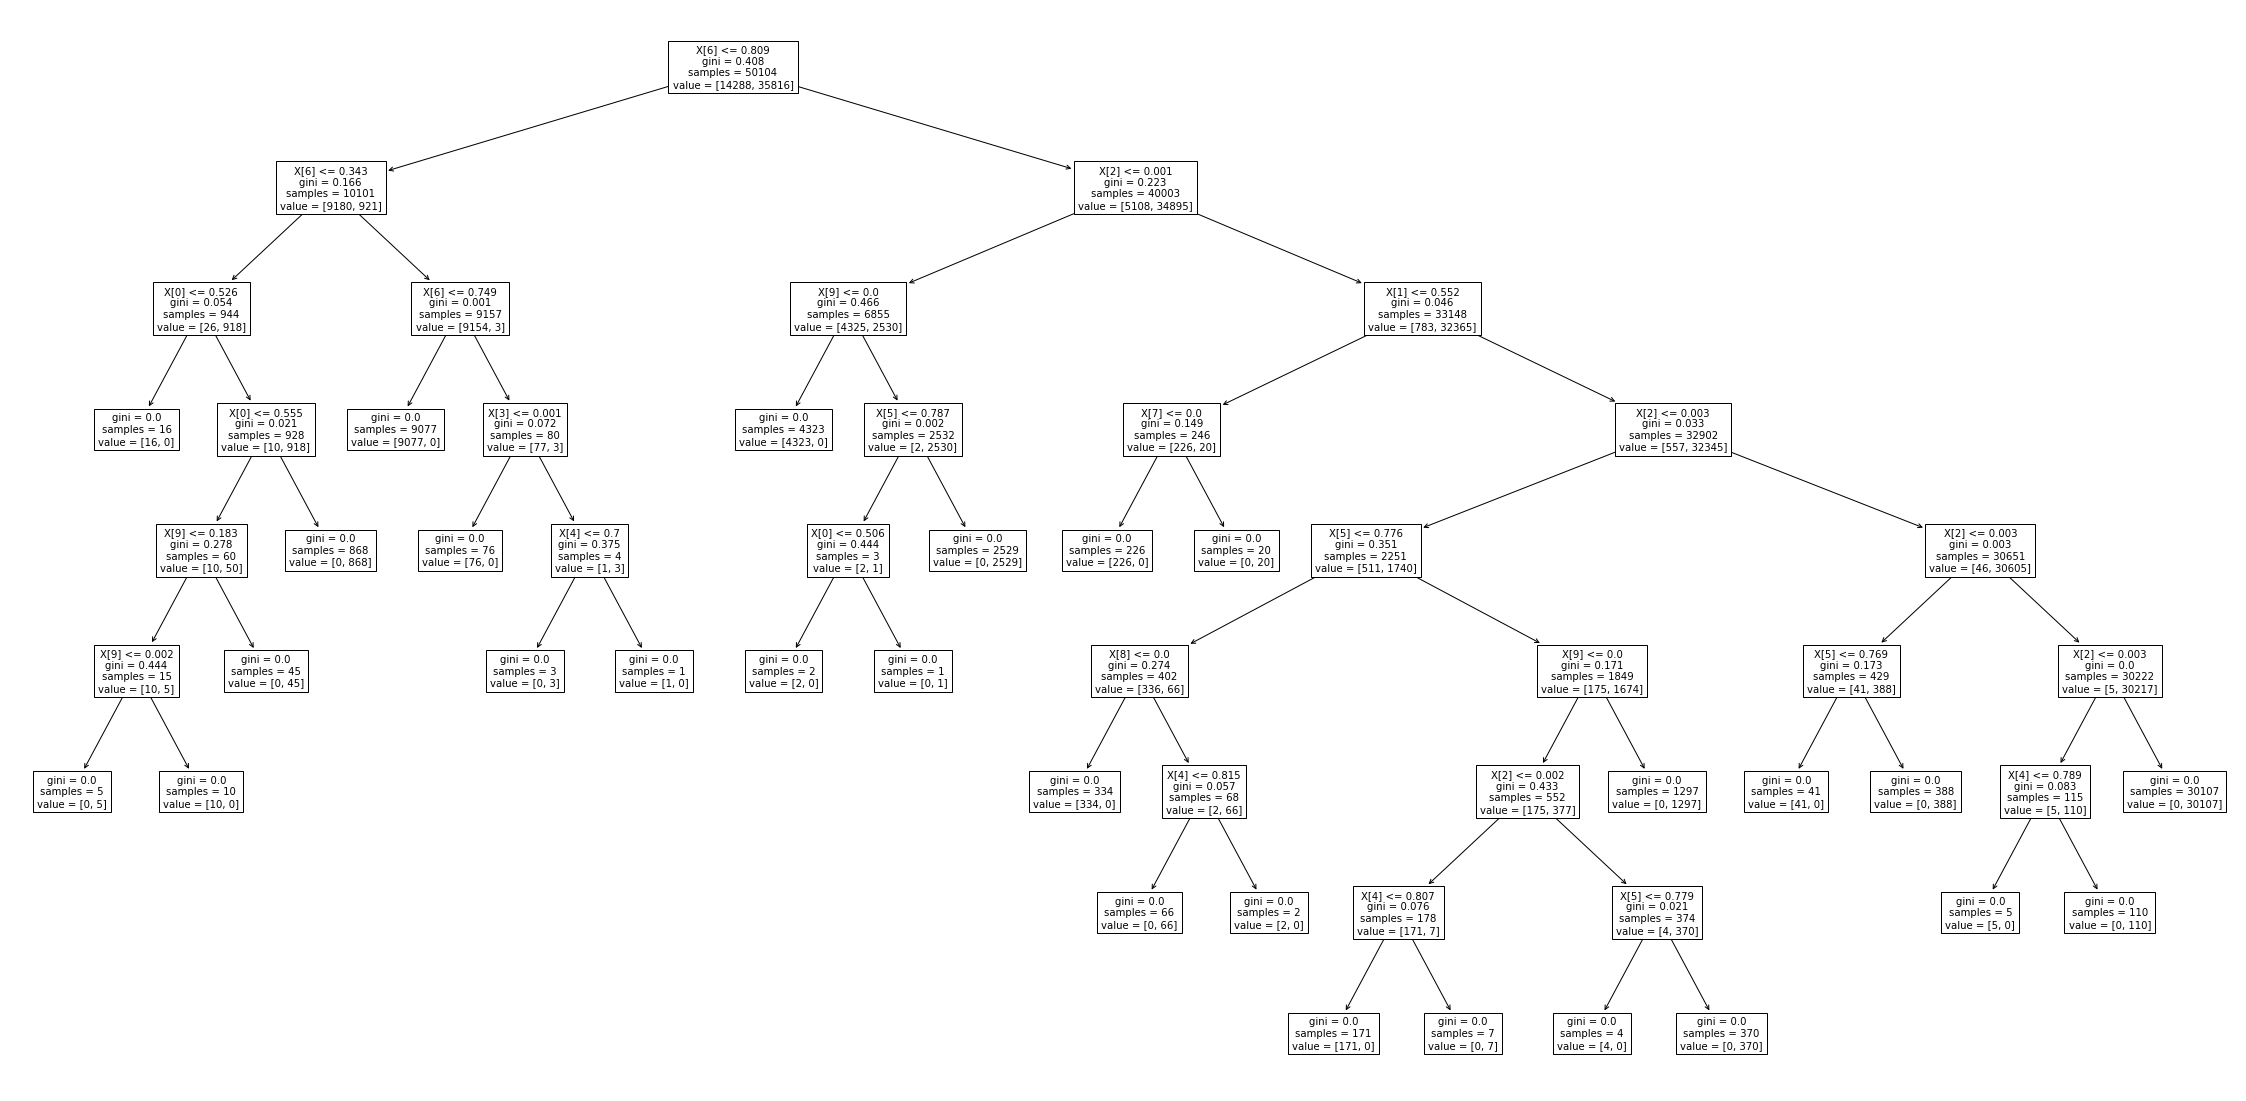

In [9]:
# params
max_depth = None
max_features = None

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# cross validation
decision_tree_clf_cv = build_decision_tree_clf(X_train, Y_train, train=False, max_depth=max_depth, max_features=max_features)
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(decision_tree_clf_cv, X, Y, cv)

# evaluate train
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
confusion_matrix_train = confusion_matrix(Y_train, Y_pred_train)

# evaluate test
confusion_matrix_test = confusion_matrix(Y_test, Y_pred_test)
tn, fp, fn, tp = confusion_matrix_test.ravel()
youden_index = (tp / (tp + fn)) + (tn / (tn + fp)) - 1

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Cross validation accuracy: {mean_accuracy} ({std_accuracy})")
print(f"Youden's index: {youden_index}")
sns.heatmap(confusion_matrix_test, annot=True, cmap='GnBu', fmt='d')
plt.show()
plt.clf()
plt.figure(figsize=(40, 20))
tree.plot_tree(decision_tree_clf)
plt.show()


results['cv_accuracy'].append(mean_accuracy)
results['experiment'].append('max_depth=8, max_features=12')
confusion_matrices['default'] = confusion_matrix_test
results['youden_index'].append(youden_index)

<a id='section332'></a>
##### Change max depth

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: 4
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 4
	tree max features: 12
Youden's index: 0.9569313913916069


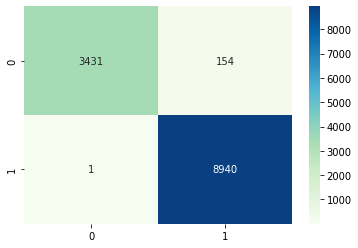

<Figure size 432x288 with 0 Axes>

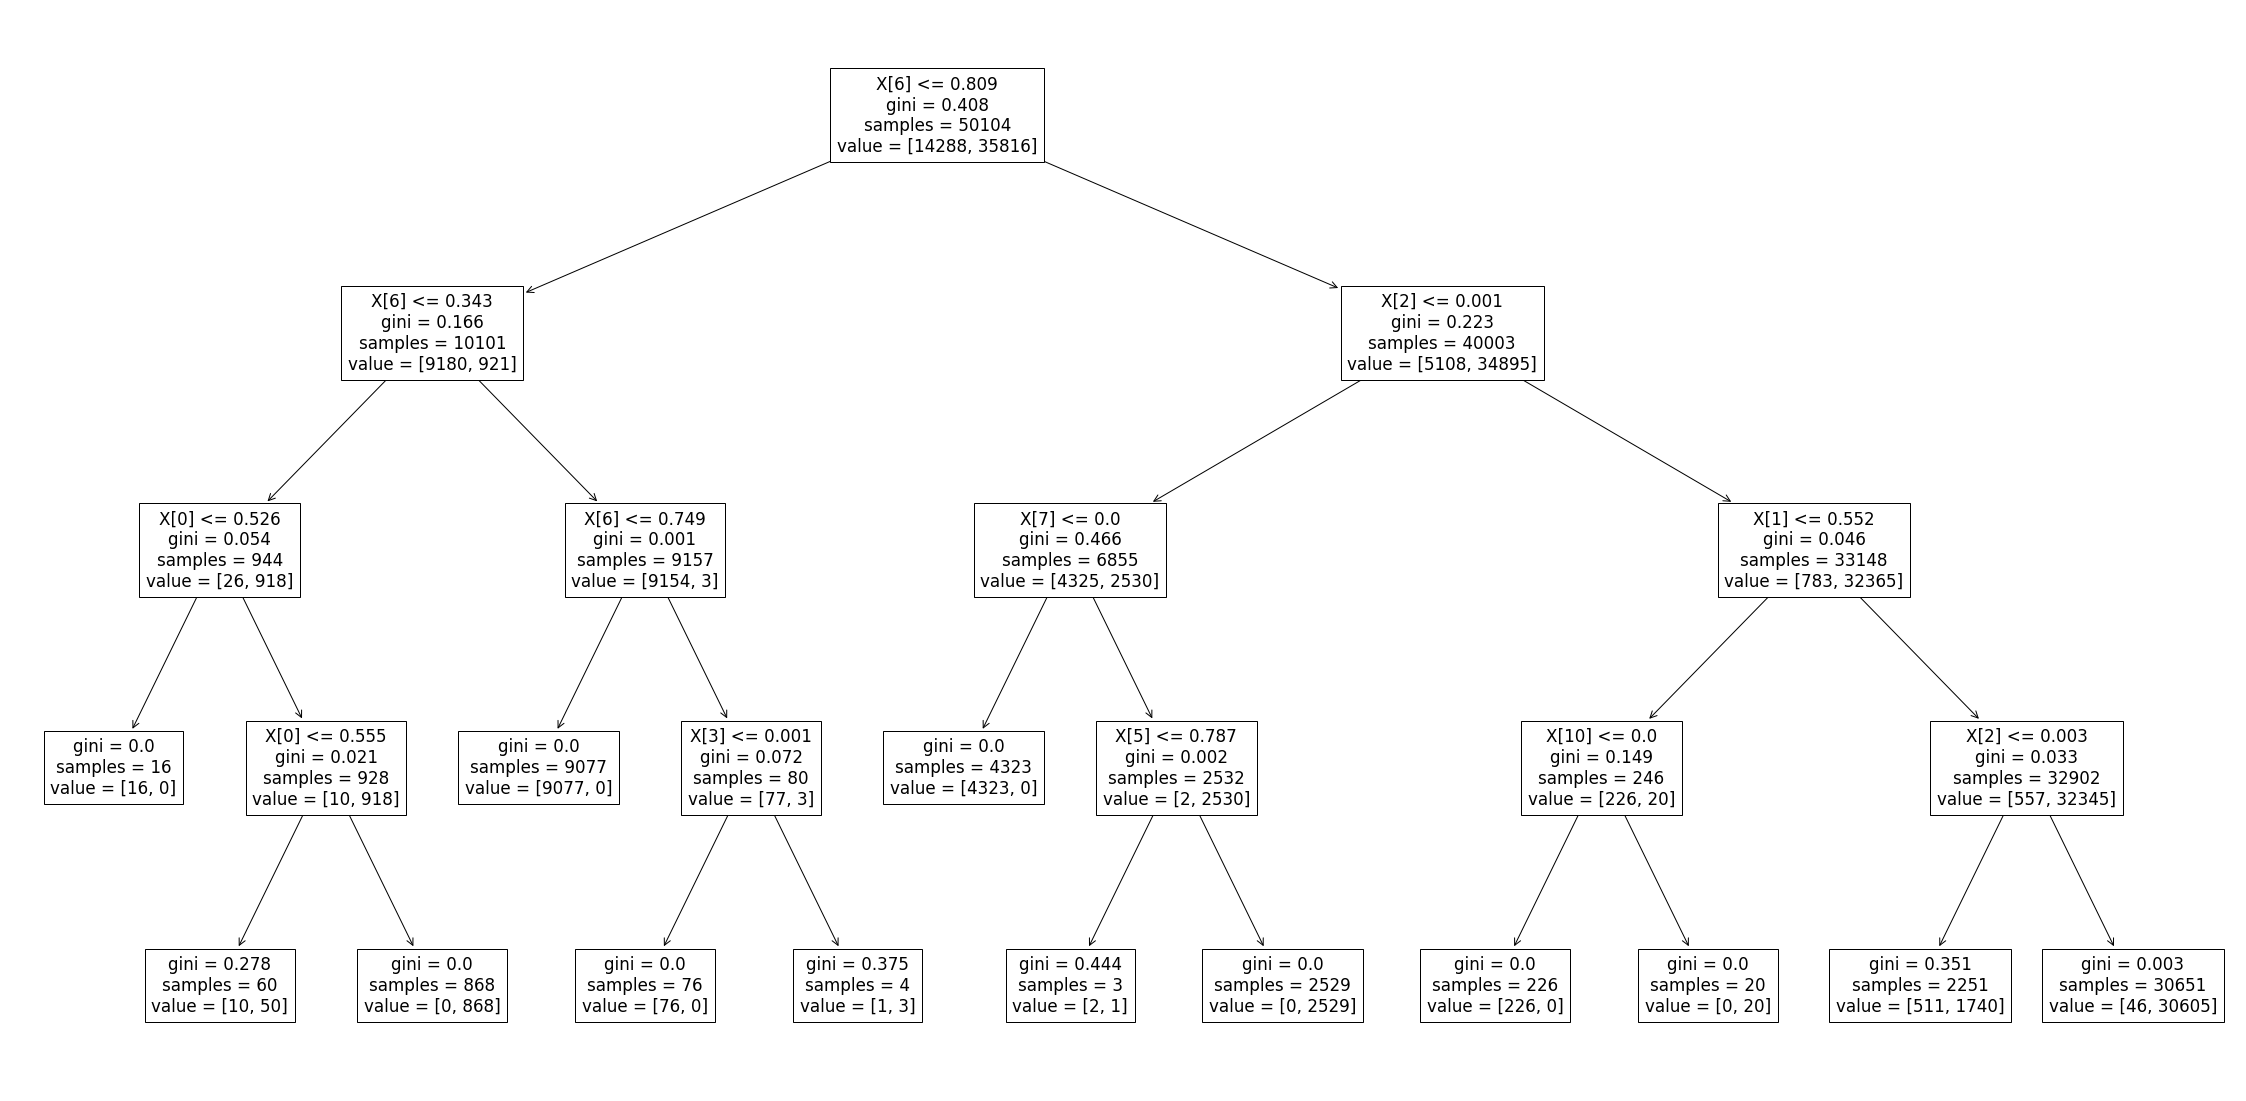

In [10]:
# params
max_depth = 4
max_features = None

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate train
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
confusion_matrix_train = confusion_matrix(Y_train, Y_pred_train)

# evaluate test
confusion_matrix_test = confusion_matrix(Y_test, Y_pred_test)
tn, fp, fn, tp = confusion_matrix_test.ravel()
youden_index = (tp / (tp + fn)) + (tn / (tn + fp)) - 1

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Youden's index: {youden_index}")
sns.heatmap(confusion_matrix_test, annot=True, cmap='GnBu', fmt='d')
plt.show()
plt.clf()
plt.figure(figsize=(40, 20))
tree.plot_tree(decision_tree_clf)
plt.show()

results['cv_accuracy'].append(-1)
results['experiment'].append('max_depth=4, max_features=12')
confusion_matrices['max_depth=4'] = confusion_matrix_test
results['youden_index'].append(youden_index)

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: 2
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 2
	tree max features: 12
Youden's index: 0.8681618862972311


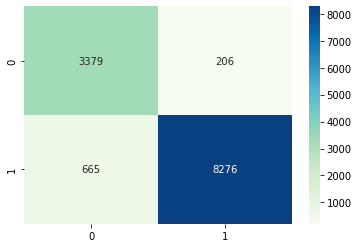

<Figure size 432x288 with 0 Axes>

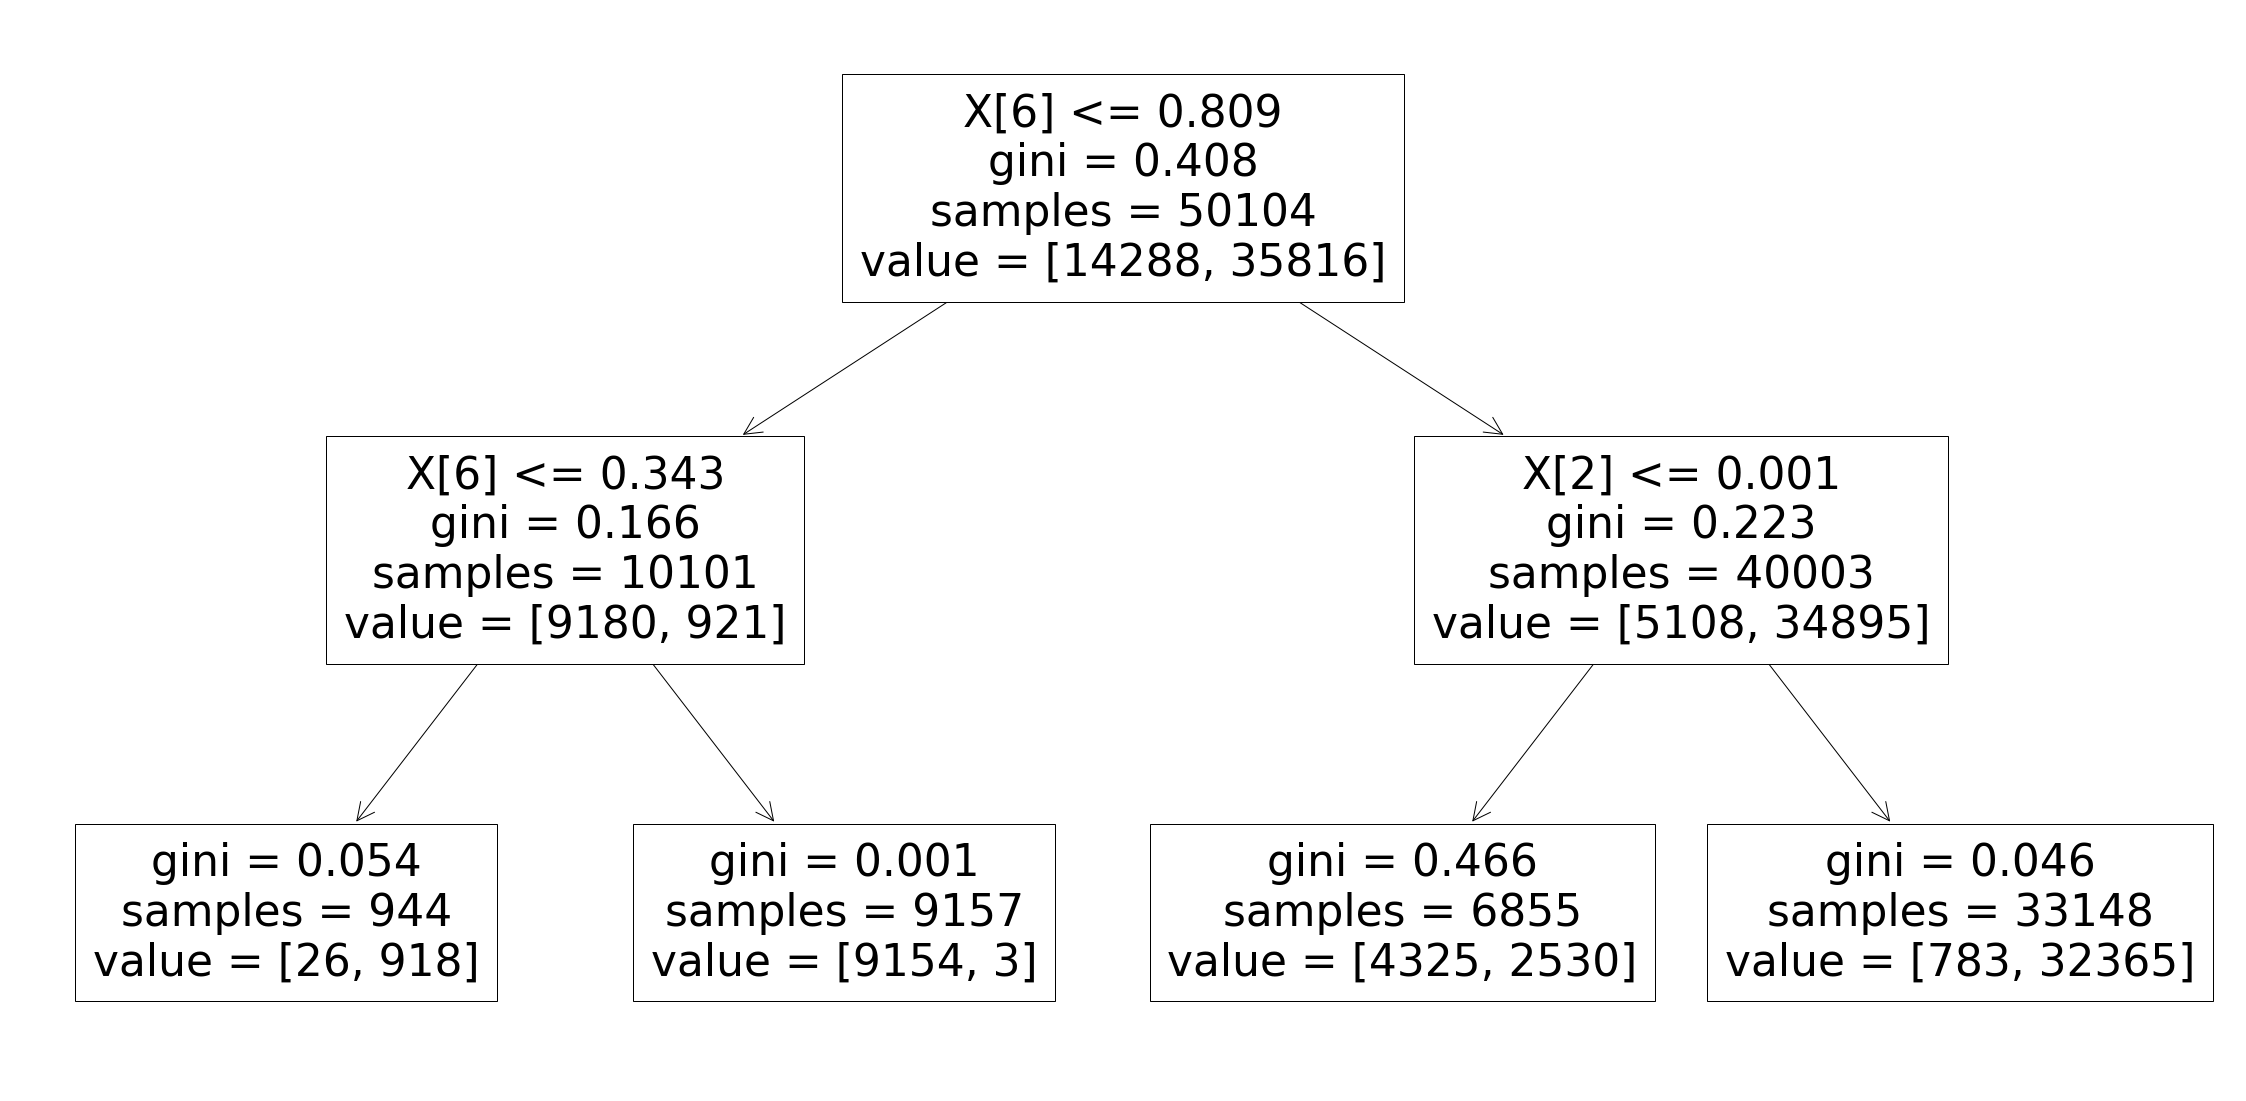

In [11]:
# params
max_depth = 2
max_features = None

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate train
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
confusion_matrix_train = confusion_matrix(Y_train, Y_pred_train)

# evaluate test
confusion_matrix_test = confusion_matrix(Y_test, Y_pred_test)
tn, fp, fn, tp = confusion_matrix_test.ravel()
youden_index = (tp / (tp + fn)) + (tn / (tn + fp)) - 1

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Youden's index: {youden_index}")
sns.heatmap(confusion_matrix_test, annot=True, cmap='GnBu', fmt='d')
plt.show()
plt.clf()
plt.figure(figsize=(40, 20))
tree.plot_tree(decision_tree_clf)
plt.show()

results['cv_accuracy'].append(-1)
results['experiment'].append('max_depth=2, max_features=12')
confusion_matrices['max_depth=2'] = confusion_matrix_test
results['youden_index'].append(youden_index)

<a id='section333'></a>
##### Change max features

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: 2
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 17
	tree max features: 2
Youden's index: 0.9847674597629554


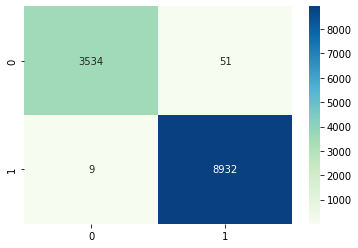

<Figure size 432x288 with 0 Axes>

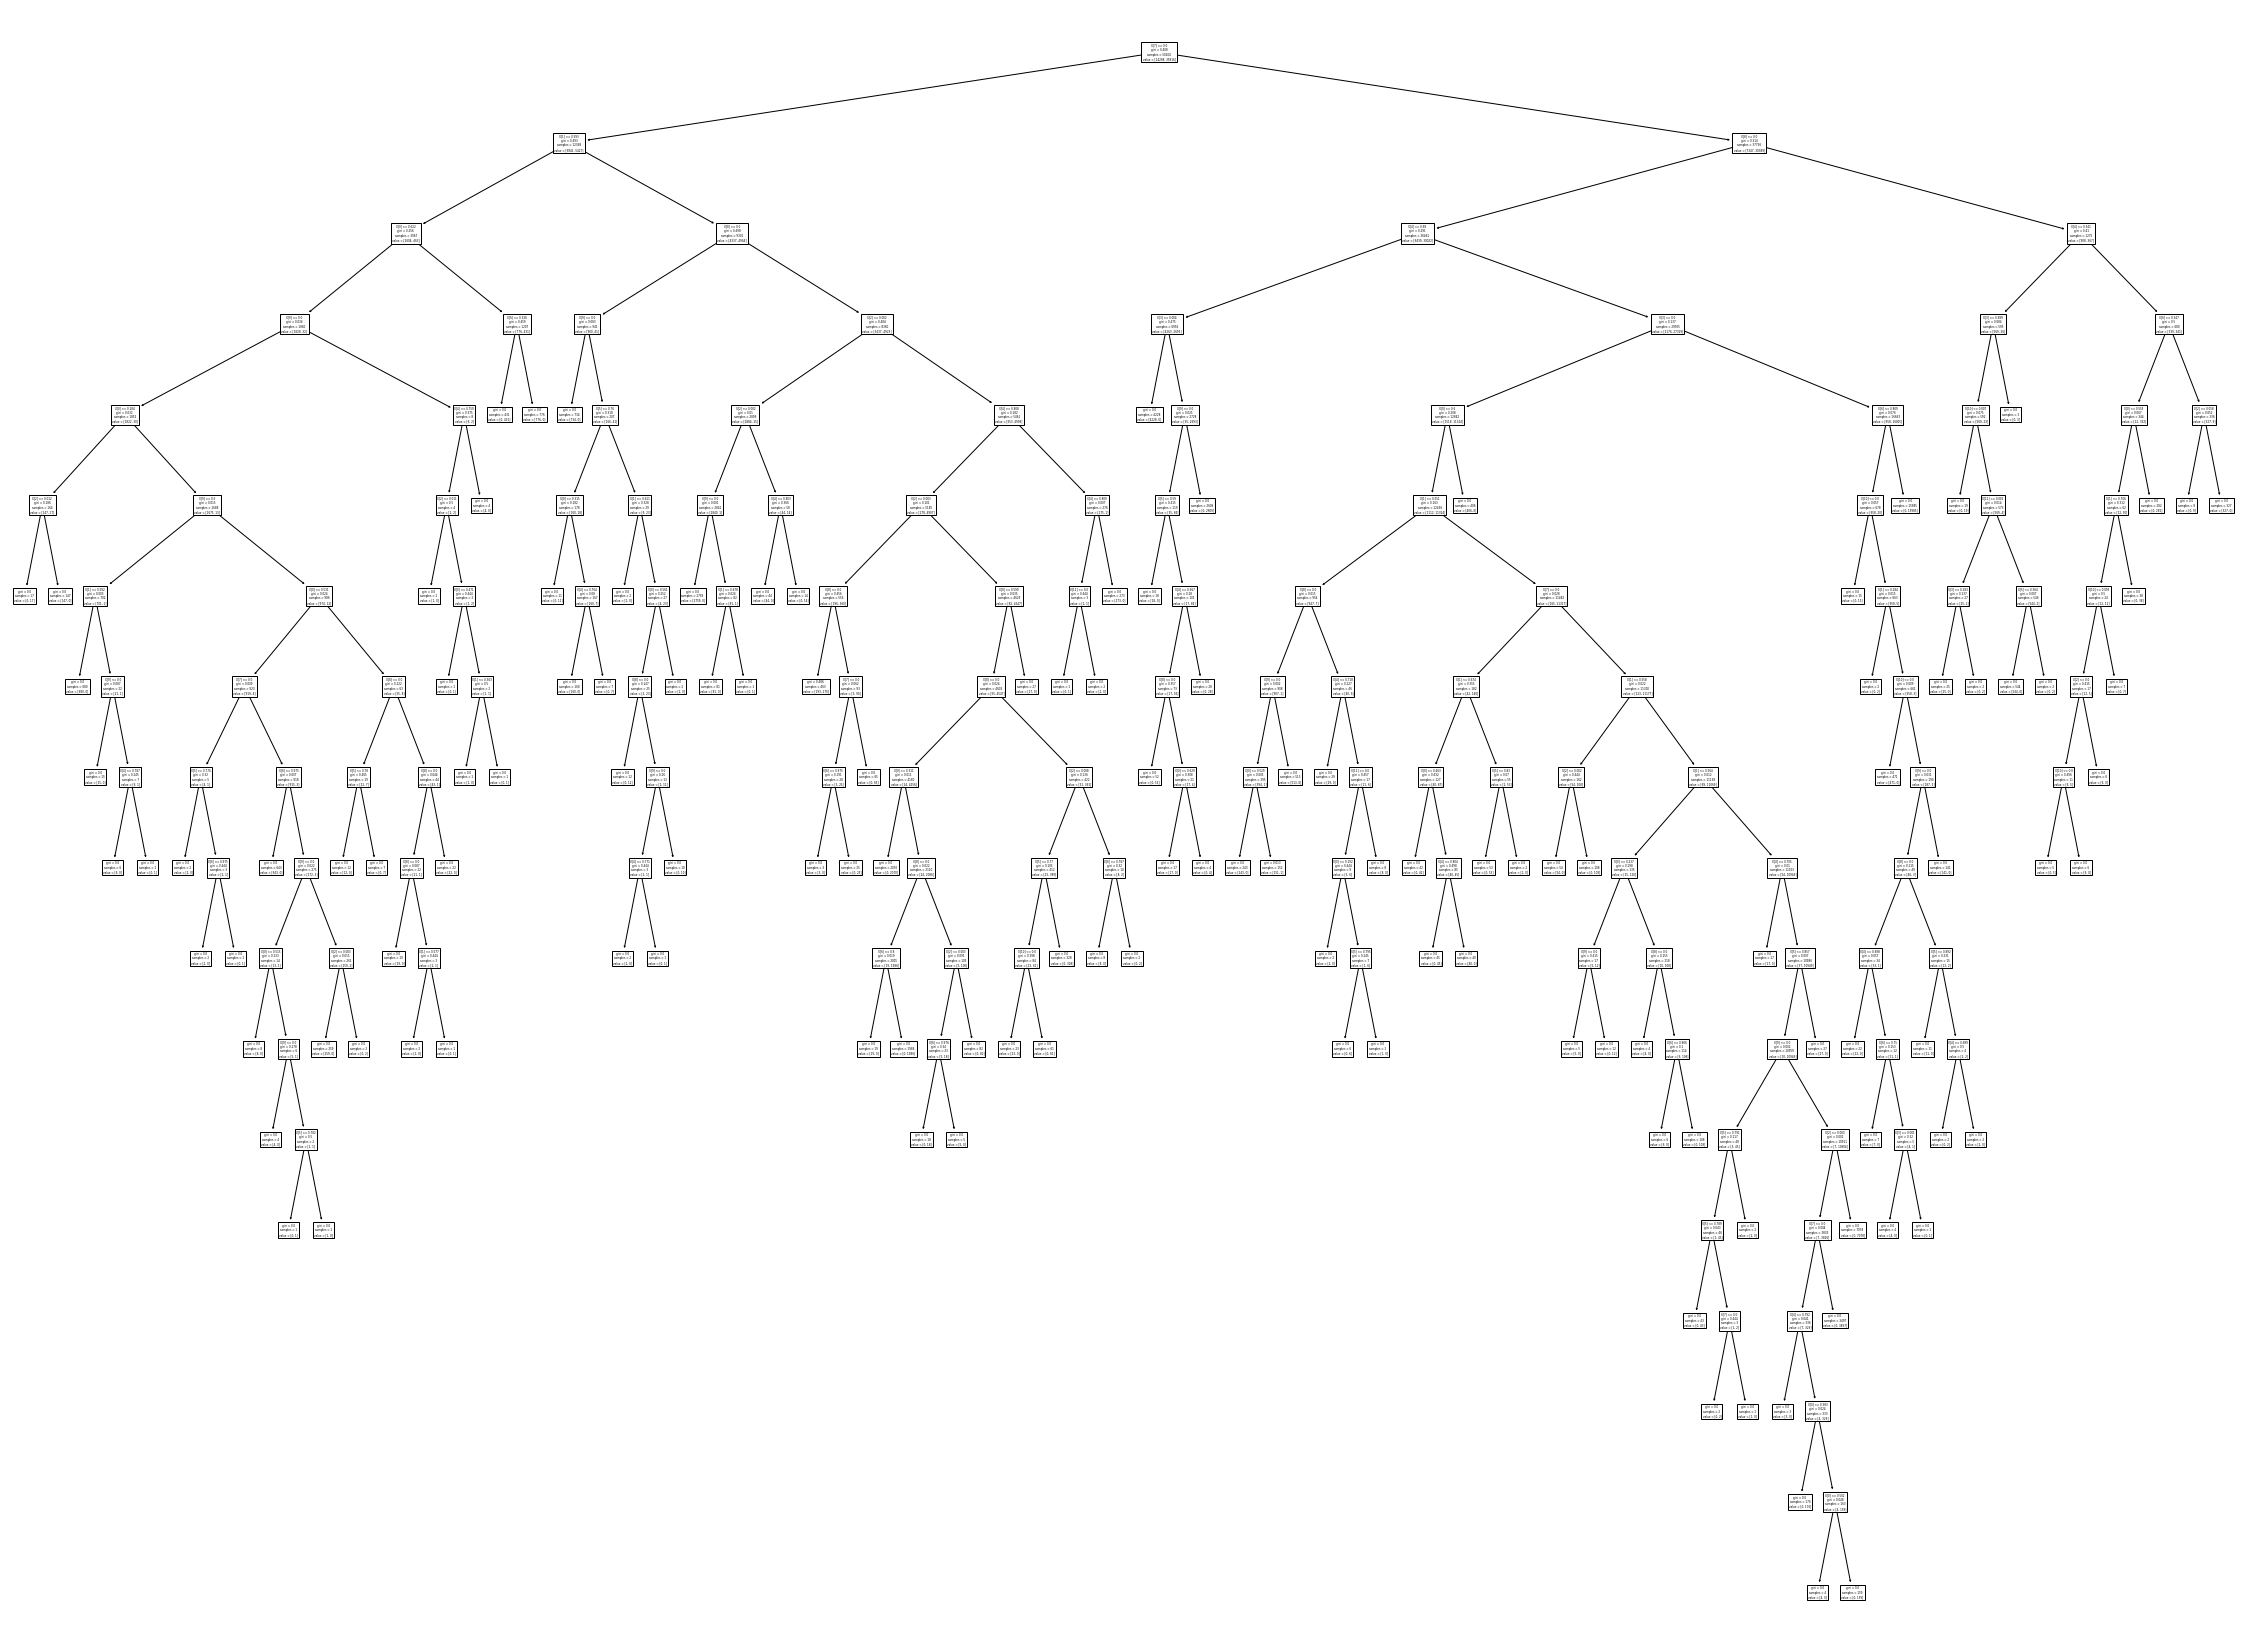

In [12]:
# params
max_depth = None
max_features = 2

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate train
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
confusion_matrix_train = confusion_matrix(Y_train, Y_pred_train)

# evaluate test
confusion_matrix_test = confusion_matrix(Y_test, Y_pred_test)
tn, fp, fn, tp = confusion_matrix_test.ravel()
youden_index = (tp / (tp + fn)) + (tn / (tn + fp)) - 1

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Youden's index: {youden_index}")
sns.heatmap(confusion_matrix_test, annot=True, cmap='GnBu', fmt='d')
plt.show()
plt.clf()
plt.figure(figsize=(40, 30))
tree.plot_tree(decision_tree_clf)
plt.show()

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: 8
	max_features: 2
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 8
	tree max features: 2
Youden's index: 0.974122127437937


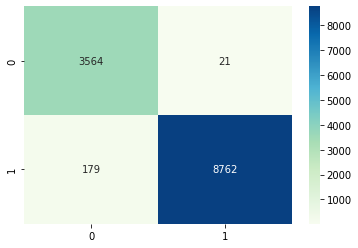

<Figure size 432x288 with 0 Axes>

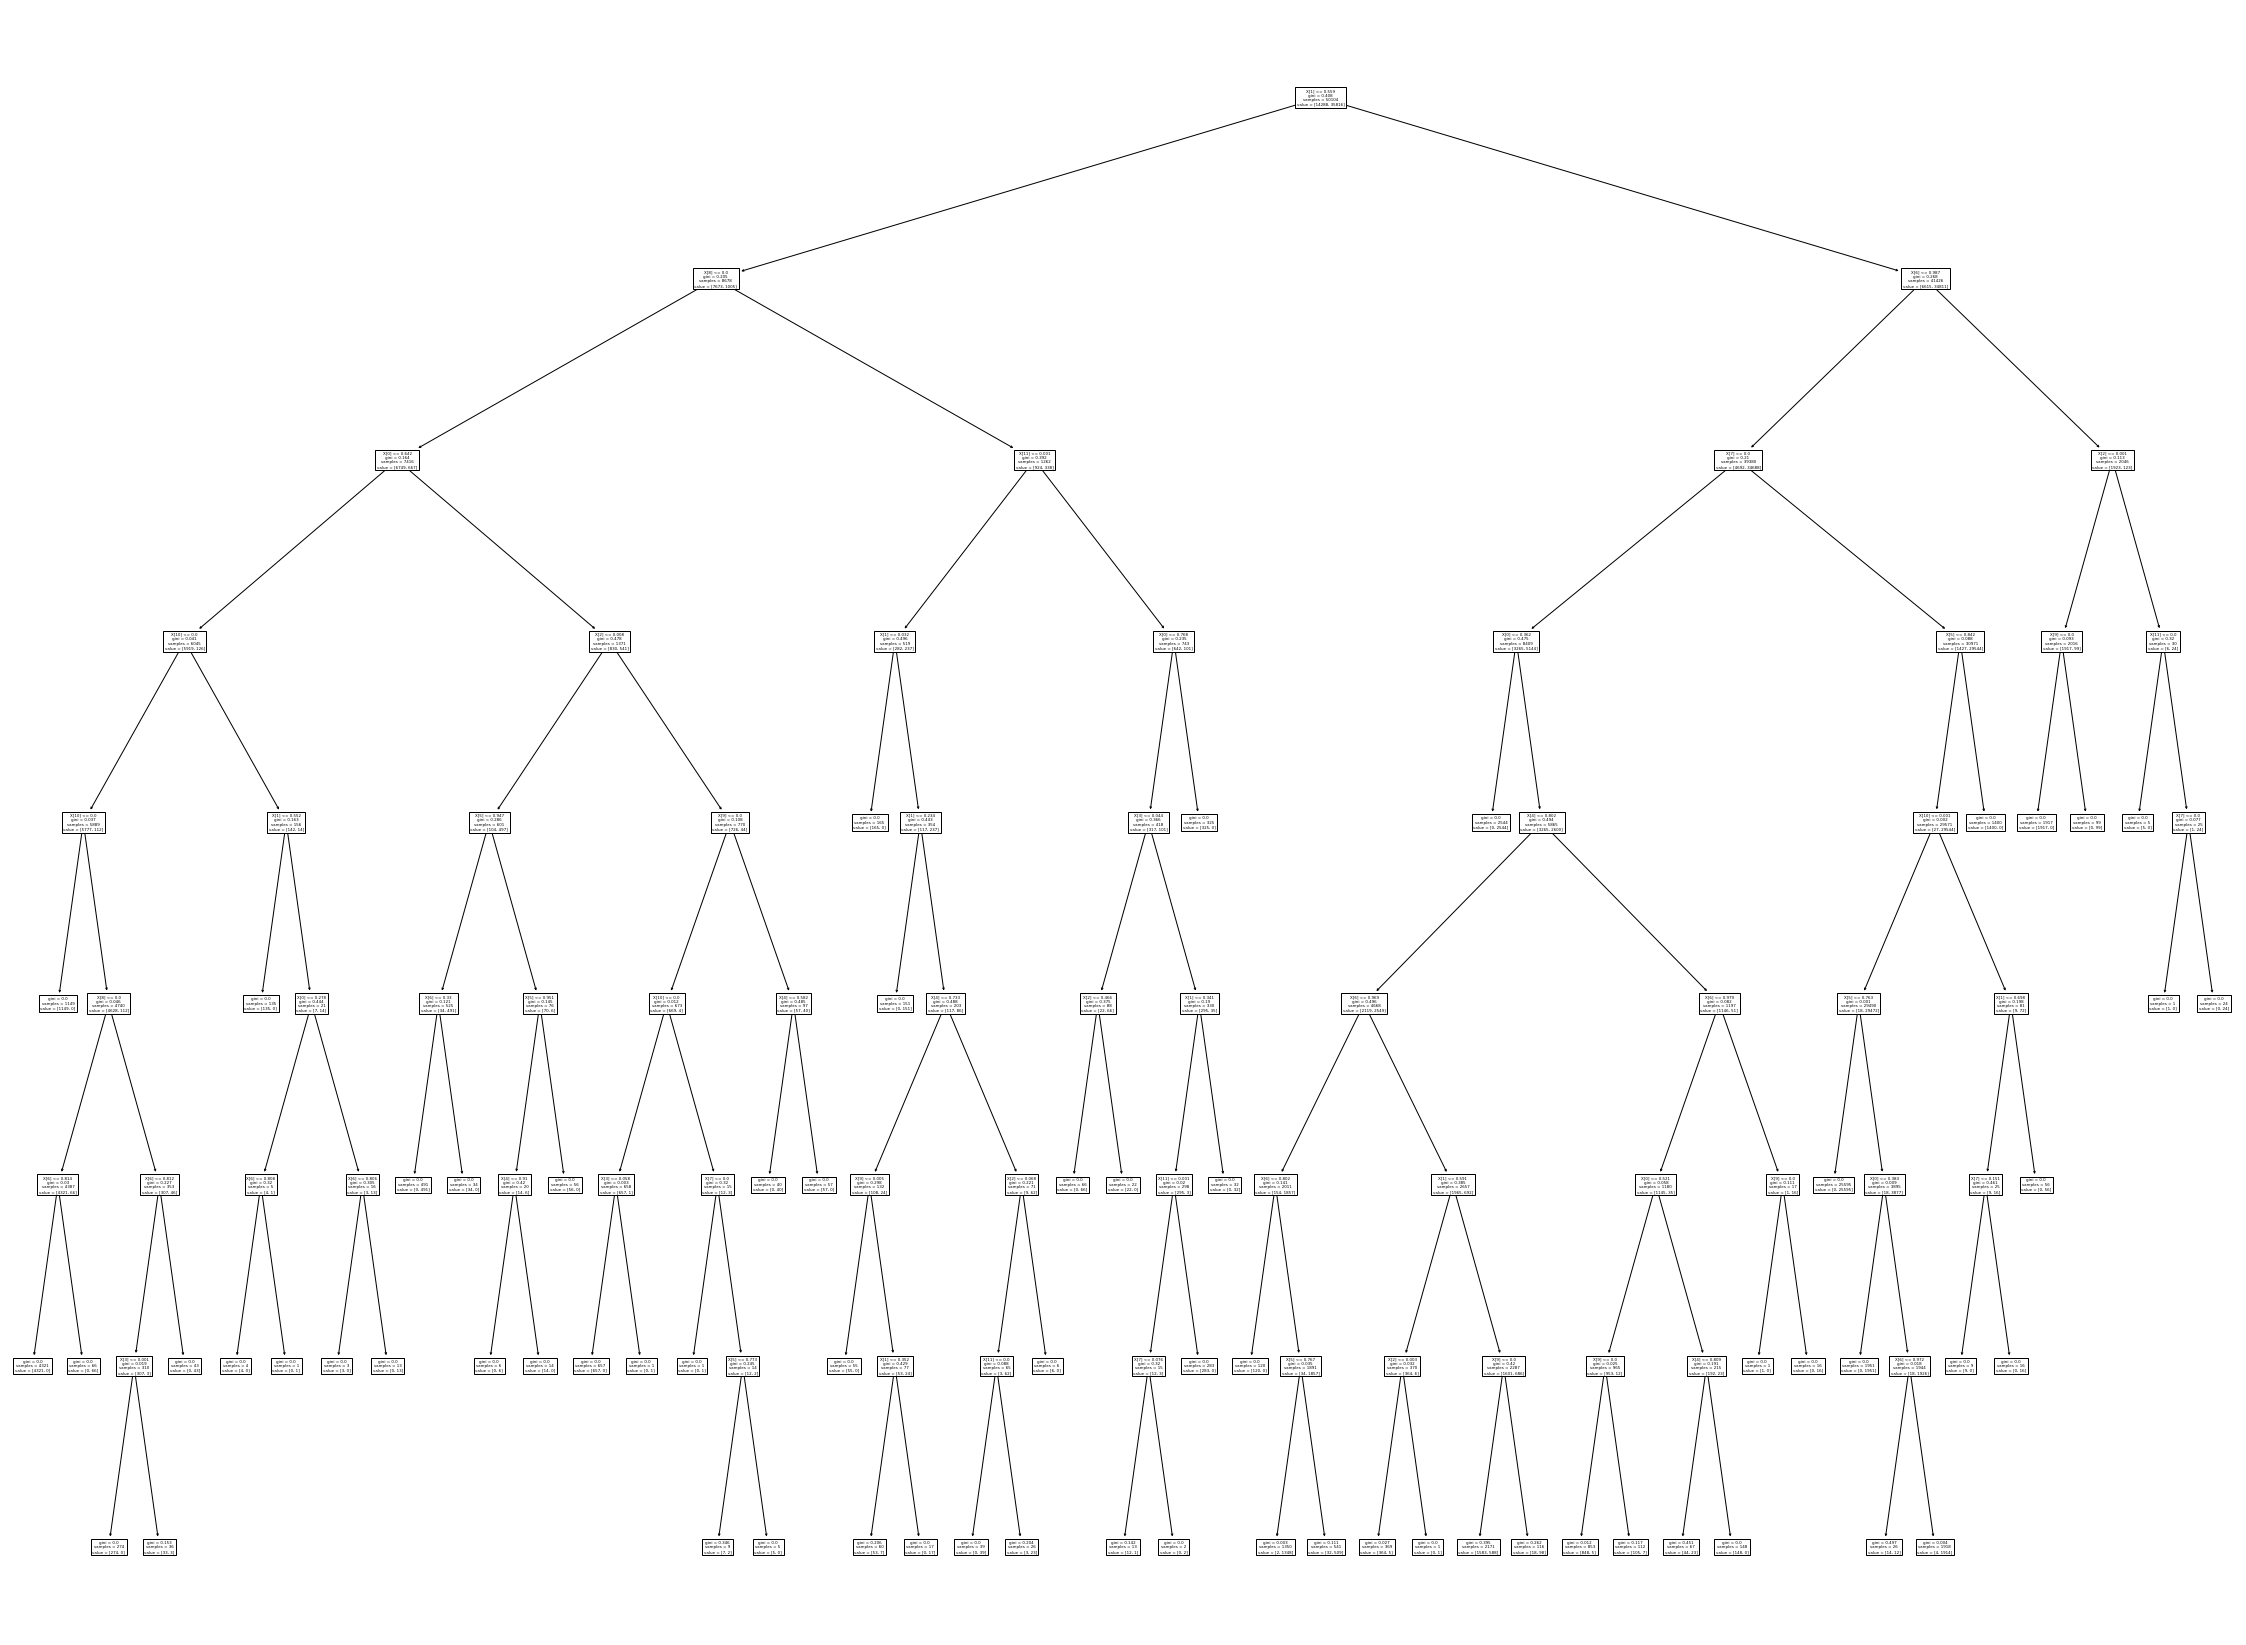

In [13]:
# params
max_depth = 8
max_features = 2

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate train
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
confusion_matrix_train = confusion_matrix(Y_train, Y_pred_train)

# evaluate test
confusion_matrix_test = confusion_matrix(Y_test, Y_pred_test)
tn, fp, fn, tp = confusion_matrix_test.ravel()
youden_index = (tp / (tp + fn)) + (tn / (tn + fp)) - 1

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Youden's index: {youden_index}")
sns.heatmap(confusion_matrix_test, annot=True, cmap='GnBu', fmt='d')
plt.show()
plt.clf()
plt.figure(figsize=(40, 30))
tree.plot_tree(decision_tree_clf)
plt.show()

results['cv_accuracy'].append(-1)
results['experiment'].append('max_depth=8, max_features=2')
confusion_matrices['max_features=2'] = confusion_matrix_test
results['youden_index'].append(youden_index)

<a id='section334'></a>
##### Analysis changes
In this experiment, I tuned two parameters which are 'max_depth' and 'max_features'. 'max_depth' is the maximum depth of the tree and 'max_features' is the number of features to consider when looking for the best split. Since my data is heavily imbalanced, the metric I used is called Youden's index which is a common summary measure of the ROC curve. From the visualizations, we can see that when the number of 'max_depth' or 'max_features' goes down, the performance of the decision tree goes down. If we didn't specify the number of 'max_depth', the decision tree will try to increase the number of 'max_depth' to fit the training data better when the number of 'max_features' goes down. Therefore, the greater the number of 'max_depth' and 'max_features', the better the performance of the decision tree.

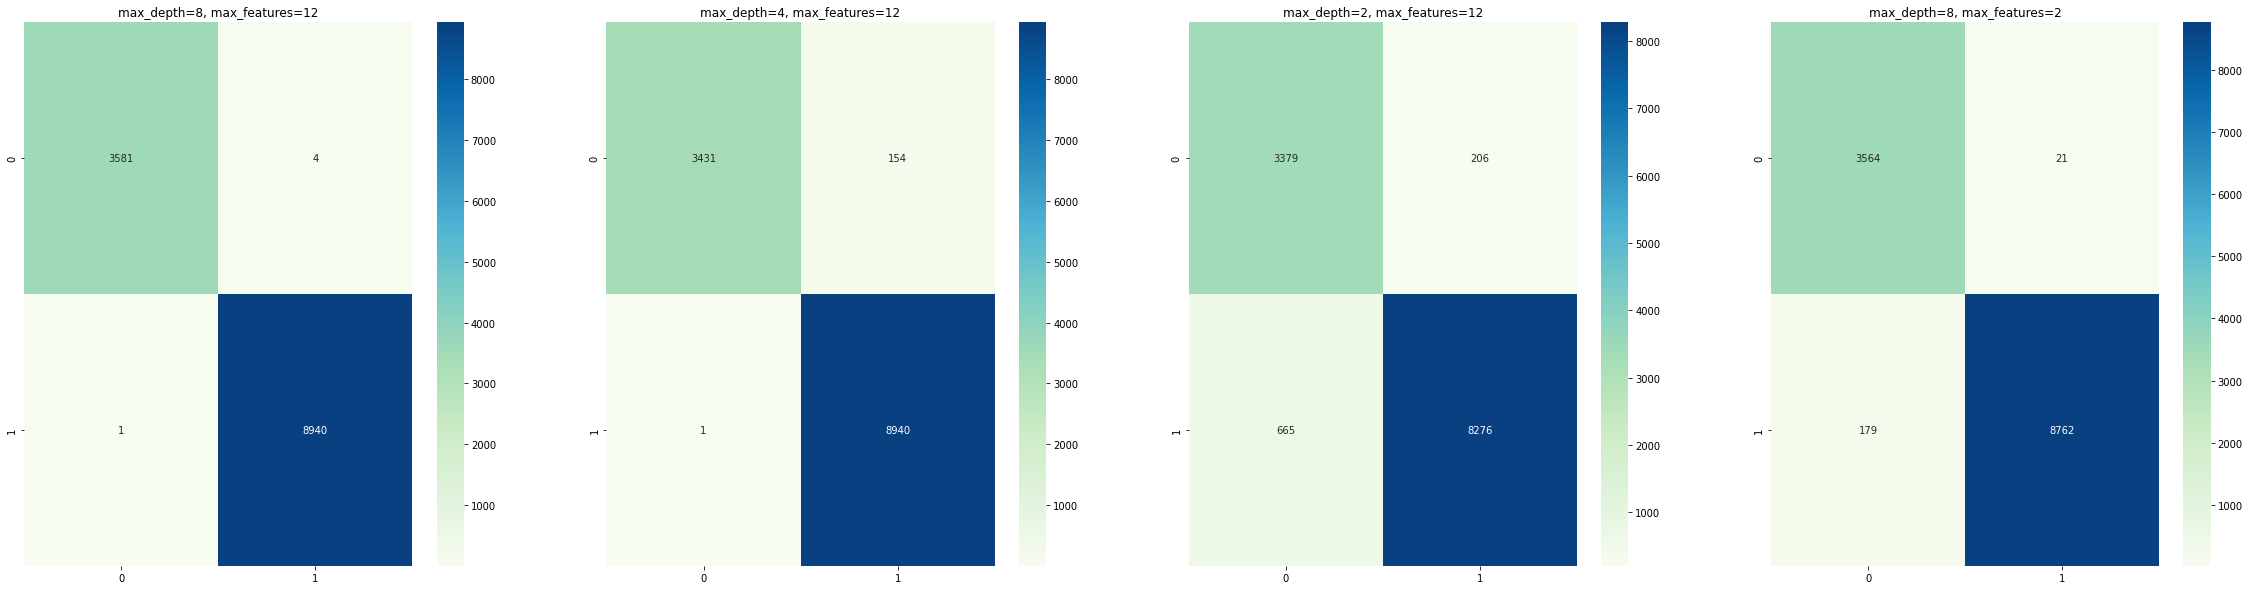

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax[0].title.set_text('max_depth=8, max_features=12')
ax[1].title.set_text('max_depth=4, max_features=12')
ax[2].title.set_text('max_depth=2, max_features=12')
ax[3].title.set_text('max_depth=8, max_features=2')
sns.heatmap(confusion_matrices['default'], annot=True, cmap='GnBu', fmt='d', ax=ax[0])
sns.heatmap(confusion_matrices['max_depth=4'], annot=True, cmap='GnBu', fmt='d', ax=ax[1])
sns.heatmap(confusion_matrices['max_depth=2'], annot=True, cmap='GnBu', fmt='d', ax=ax[2])
sns.heatmap(confusion_matrices['max_features=2'], annot=True, cmap='GnBu', fmt='d', ax=ax[3])
fig.show()

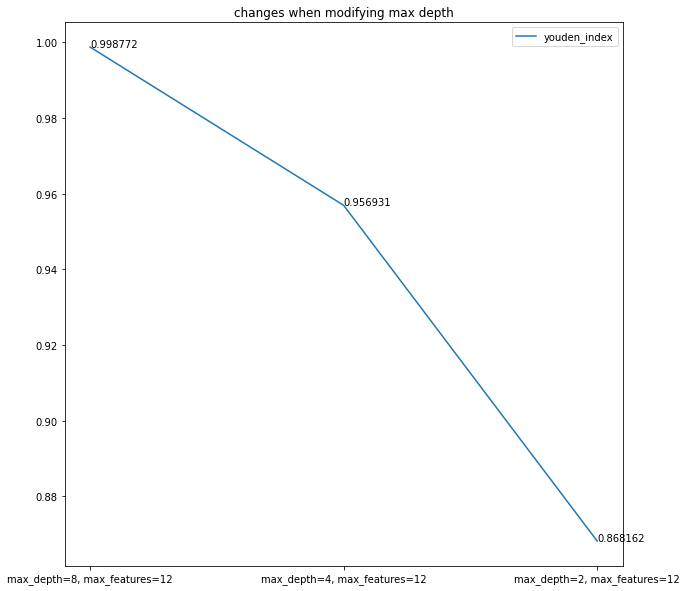

In [15]:
results_df = pd.DataFrame(results, columns=['experiment', 'youden_index'])
x = [1, 2, 3]
y = results_df[:3].values[:, 1]
labels = results_df[:3].values[:, 0]
plt.figure(figsize=(10, 10))
plt.plot(x, y)
plt.xticks(x, labels)
plt.title("changes when modifying max depth")
plt.legend(['youden_index'])
for i, j in enumerate(y):
    plt.text(i+1, j, f"{j:.6f}")
plt.show()

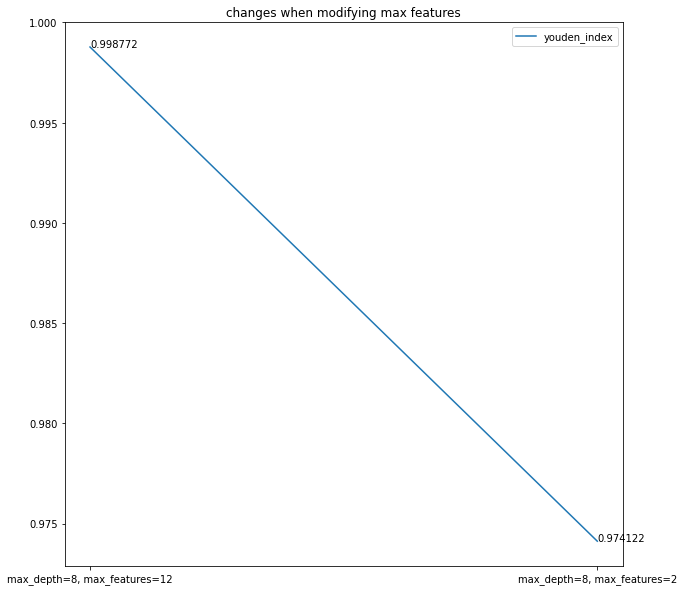

In [16]:
results_df = pd.DataFrame(results, columns=['experiment', 'youden_index'])
x = [1, 2]
y = [results_df.values[0, 1]] + [results_df.values[3, 1]]
labels = [results_df.values[0, 0]] + [results_df.values[3, 0]]
plt.figure(figsize=(10, 10))
plt.plot(x, y)
plt.title("changes when modifying max features")
plt.xticks(x, labels)
plt.legend(['youden_index'])
for i, j in enumerate(y):
    plt.text(i+1, j, f"{j:.6f}")
plt.show()

<a id='section4'></a>
### Bagging and Boosting

<a id='section41'></a>
#### Bagging

In [17]:
def build_bagging_clf(n_estimator=50):
    clf = BaggingClassifier(n_estimators=n_estimator)
    return clf

In [18]:
bagging_clf = build_bagging_clf(n_estimator=4)
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(bagging_clf, X, Y, cv)
print(f"Cross validation accuracy(n_estimator=4): {mean_accuracy} ({std_accuracy})")

results['cv_accuracy'].append(mean_accuracy)
results['experiment'].append('bagging, n_estimator=4')

Cross validation accuracy(n_estimator=4): 0.9999585209350965 (0.00013521877842780972)


In [19]:
bagging_clf = build_bagging_clf(n_estimator=100)
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(bagging_clf, X, Y, cv)
print(f"Cross validation accuracy(n_estimator=100): {mean_accuracy} ({std_accuracy})")

results['cv_accuracy'].append(mean_accuracy)
results['experiment'].append('bagging, n_estimator=100')

Cross validation accuracy(n_estimator=100): 0.9999943215164628 (3.9329983037061776e-05)


<a id='section42'></a>
#### Boosting

In [20]:
def build_boosting_clf(X, Y, algorithm='SAMME.R', n_estimator=50):
    clf = AdaBoostClassifier(n_estimators=n_estimator, algorithm=algorithm)
    return clf

In [21]:
boosting_clf = build_boosting_clf(X, Y, n_estimator=4)
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(boosting_clf, X, Y, cv)
print(f"Cross validation accuracy(n_estimator=4): {mean_accuracy} ({std_accuracy})")

results['cv_accuracy'].append(mean_accuracy)
results['experiment'].append('boosting, n_estimator=4')

Cross validation accuracy(n_estimator=4): 0.9897271716799457 (0.001086992614431188)


In [22]:
boosting_clf = build_boosting_clf(X, Y, n_estimator=100)
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(boosting_clf, X, Y, cv)
print(f"Cross validation accuracy(n_estimator=100): {mean_accuracy} ({std_accuracy})")

results['cv_accuracy'].append(mean_accuracy)
results['experiment'].append('boosting, n_estimator=100')

Cross validation accuracy(n_estimator=100): 0.9999795665723811 (9.131984453363653e-05)


<a id='section43'></a>
#### Analysis three different models
The metric I used here is the ROCAUC-score since my data is heavily imbalanced with fewer positive samples. ROCAUC-score can show the performance of the model at distinguishing between the positive and negative classes.  
- Task-2: Based on the observation of changing 'n_estimator', boosting requires less training time than bagging to achieve the similar ROCAUC-score which means boosting is more efficient than bagging. Boosting perform much worse than bagging when having low 'n_estimator' and have similar results when 'n_estimator' is high enough.  
- Task-3: The default decision tree has the fastest speed but the lowest score. Even a the worst model in bagging and boosting is better than the default decision tree. If I choose plain accuracy as my metric, I will not be able to show the ability of this model to classify the class which has less occurrence.

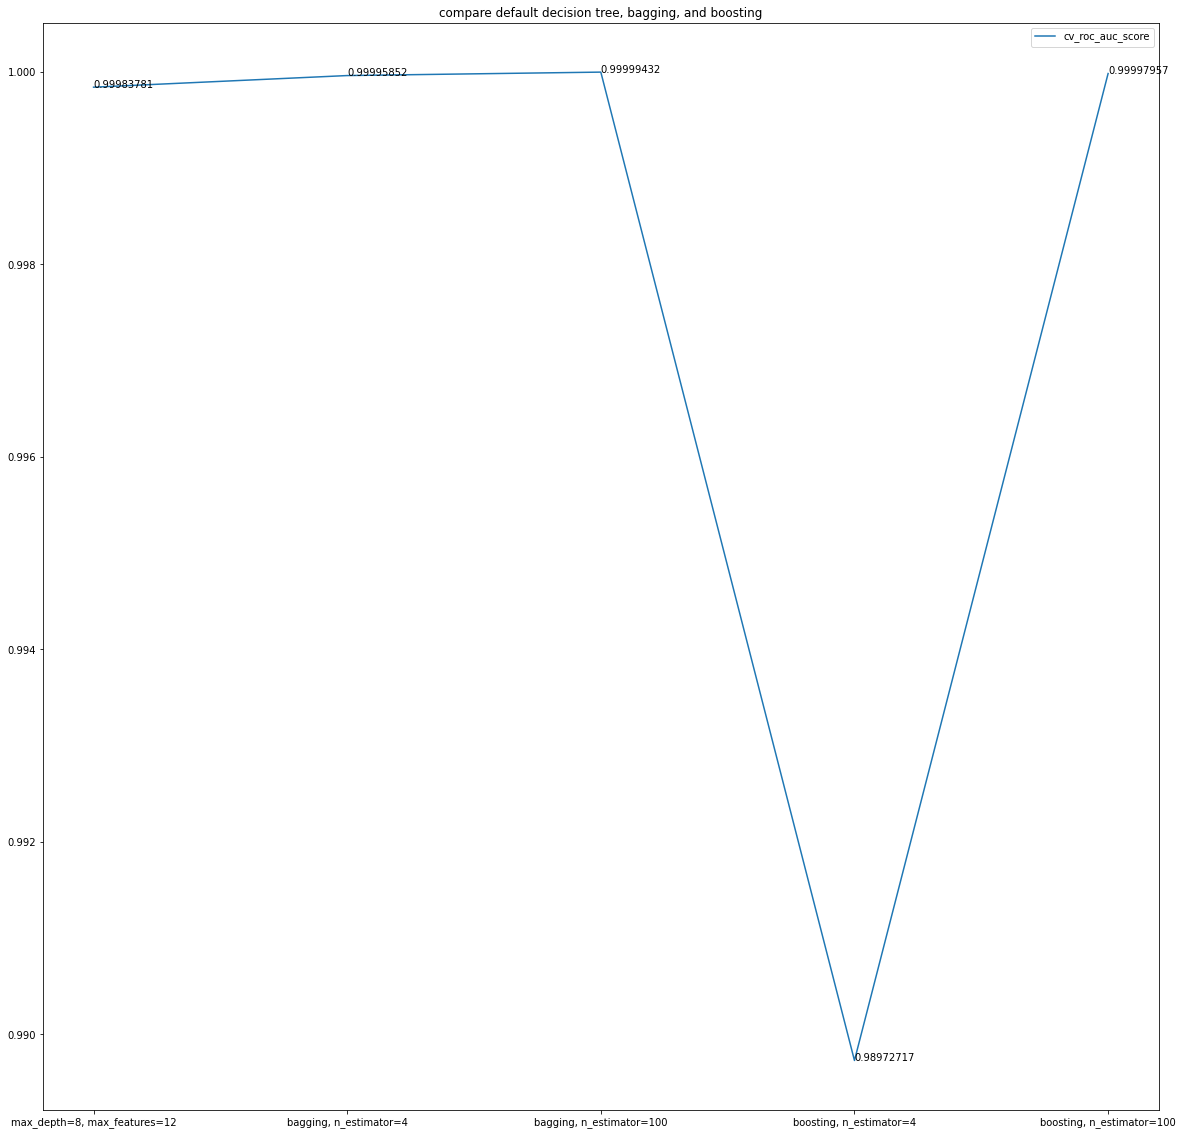

In [23]:
results_df = pd.DataFrame(results, columns=['experiment', 'cv_accuracy'])
x = [1, 2, 3, 4, 5]
y = [results_df.values[0, 1]]
labels = [results_df.values[0, 0]]
for i in range(4, 8):
    y.append(results_df.values[i, 1])
    labels.append(results_df.values[i, 0])
plt.figure(figsize=(20, 20))
plt.plot(x, y)
plt.xticks(x, labels)
plt.title("compare default decision tree, bagging, and boosting")
plt.legend(['cv_roc_auc_score'])
for i, j in enumerate(y):
    plt.text(i+1, j, f"{j:.8f}")
plt.show()